# МО для HR-аналитики компании «Работа с заботой»

Проект посвящён разработке двух моделей машинного обучения, которые помогут HR-аналитикам компании «Работа с заботой» предсказывать уровень удовлетворённости сотрудника и вероятность увольнения. Для исследования нужно будет составить портрет «уволившегося сотрудника» и добавить новый входной признак 'job_satisfaction_rate'. 

In [20]:
# загружаю все нужные для проекта библиотеки

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import shap
import phik

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [15]:
def load_data(file_name):
    """
    Load data from a CSV file and display its head and info.

    This function reads a CSV file, with data separated by semicolons and decimals
    denoted by commas, into a pandas DataFrame. It also displays the first few rows of the
    DataFrame (the head) and summarizes the columns.

    Parameters
    ----------
    file_name : str
        The name (and path, if necessary) of the CSV file from which to load data.

    Returns
    -------
    data : pandas.DataFrame
        The data loaded from the CSV file.
    """
    data = pd.read_csv(file_name)  # разделила данные в датасете по столбцам и поправила разделитель в дробях
    print(data.head())
    data.info()
    return data


def clean_columns(data):
    """
    Cleans the column names of a pandas DataFrame.

    :param data: The pandas DataFrame to clean the column names of.
    :type data: pandas.DataFrame
    :return: The pandas DataFrame with cleaned column names.
    :rtype: pandas.DataFrame
    """
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    print(data.head())
    return data

def plot_cat_data(data, title, ax):
    """
    Plot a countplot for the given categorical data.

    Parameters
    ----------
    data : array-like
        The categorical data to be plotted as a countplot. This could be a list, 1D-array or series.
    title : string
        The title of the plot.
    ax : matplotlib.axes.Axes instance
        The axes upon which to draw the plot.

    Returns
    -------
    None
    """
    sns.countplot(x=data, ax=ax)
    ax.set_title(title)

def plot_num_data(data, title, ax):
    """
    Plot a boxplot (also known as whisker plot) for the given numerical data.

    Parameters
    ----------
    data : array-like
        The numerical data to be plotted as a boxplot. This could be a list, 1D-array or series.
    title : string
        The title of the plot.
    ax : matplotlib.axes.Axes instance
        The axes upon which to draw the plot.

    Returns
    -------
    None
    """
    sns.boxplot(data=data, ax=ax) # ящик с усами
    ax.set_title(title)

def hist_num_data(data, title, ax):
    """
    Plot a histogram of the given data.

    Parameters
    ----------
    data : array-like
        The input data to be plotted as a histogram.
    title : str
        The title to be set for the histogram.
    ax : matplotlib.axes.Axes
        The axes object on which the histogram is to be plotted.

    Returns
    -------
    None
    """
    sns.histplot(data=data, ax=ax) # гистограмма
    ax.set_title(title)

def data_for_model(data, drop_col, ohe_col, ord_col, num_col, test_size = 0.25, random_state=42, stratify = None):
    """
    Prepare data for a machine learning model. The function splits the data into training and test sets, 
    applies one-hot encoding, ordinal encoding and scaling to the appropriate columns.

    Parameters
    ----------
    data : DataFrame
        The input data to be prepared for the model.
    drop_col : list
        The columns to be dropped from the input data.
    ohe_col : list
        The columns to be one-hot encoded.
    ord_col : list
        The columns to be ordinal encoded.
    num_col : list
        The numerical columns to be scaled.
    test_size : float, optional
        The proportion of the dataset to include in the test split, by default 0.25.
    random_state : int, optional
        The seed used by the random number generator, by default 42.
    stratify : array-like, optional
        If not None, data is split in a stratified fashion, using this as the class labels.

    Returns
    -------
    X_train : DataFrame
        The training data after preprocessing.
    X_test : DataFrame
        The test data after preprocessing.
    y_train : Series
        The training labels.
    y_test : Series
        The test labels.
    scaler : MinMaxScaler
        The scaler used to scale the numerical columns.
    ohe_encoder : OneHotEncoder
        The one-hot encoder used to encode the one-hot columns.
    ord_encoder : OrdinalEncoder
        The ordinal encoder used to encode the ordinal columns.
    """

    X = data.drop(drop_col, axis=1)
    y = data[drop_col[0]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

    ohe_encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_col])
    X_test_ohe = ohe_encoder.transform(X_test[ohe_col])
    encoder_ohe_names = ohe_encoder.get_feature_names_out()
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_ohe_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_ohe_names)

    ord_encoder = OrdinalEncoder()
    X_train_ord = ord_encoder.fit_transform(X_train[ord_col])
    X_test_ord = ord_encoder.transform(X_test[ord_col])
    X_train_ord = pd.DataFrame(X_train_ord, columns=ord_col)
    X_test_ord = pd.DataFrame(X_test_ord, columns=ord_col)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col])
    X_test_scaled = scaler.transform(X_test[num_col])
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

    X_train = pd.concat([X_train_ohe, X_train_ord, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_ord, X_test_scaled], axis=1)

    return X_train, X_test, y_train, y_test, scaler, ohe_encoder, ord_encoder

## Загрузка и изучение данных для первой модели

In [16]:
job_satisfaction_rate = load_data('/Users/ira-bobrineva/Downloads/train_job_satisfaction_rate.csv')


       id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 

In [17]:
test_features = load_data('/Users/ira-bobrineva/Downloads/test_features.csv')

       id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   

In [18]:
test_target_job_satisfaction_rate = load_data('/Users/ira-bobrineva/Downloads/test_target_job_satisfaction_rate.csv')

       id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Полных дубликатов в данных нет, со столбцами всё хорошо, только есть пропущенные значения в некоторых. Обработаю их с помощью SimpleImputer в пайплайне.

## Исследовательский анализ

In [27]:
job_satisfaction_rate

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


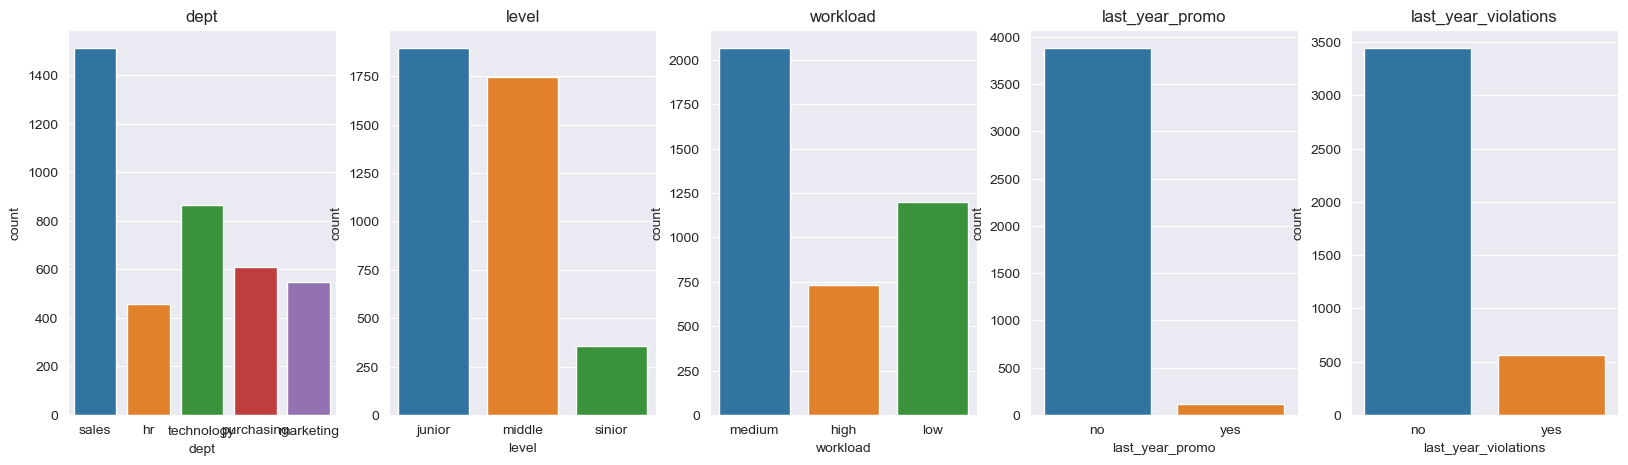

In [33]:
job_satisfaction_cat = job_satisfaction_rate[['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']]

fig, axs = plt.subplots(1, len(job_satisfaction_cat.columns), figsize=(20, 5))

for i, cat in enumerate(job_satisfaction_cat):
    # строю столбчатые диаграммы
    plot_cat_data(job_satisfaction_cat[cat], cat, axs[i])

В компании очень маленький процент повышений за прошлый год. Это может плохо сказываться на мотивации сотрудников.

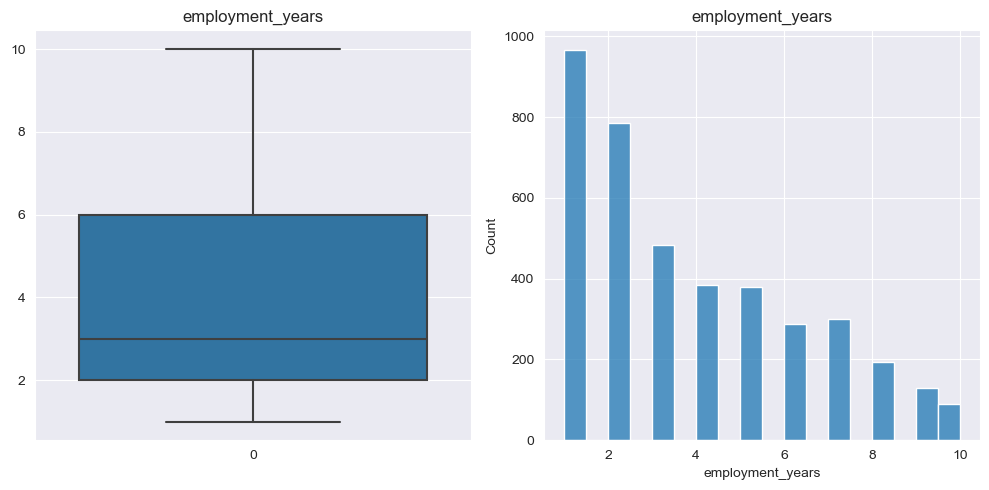

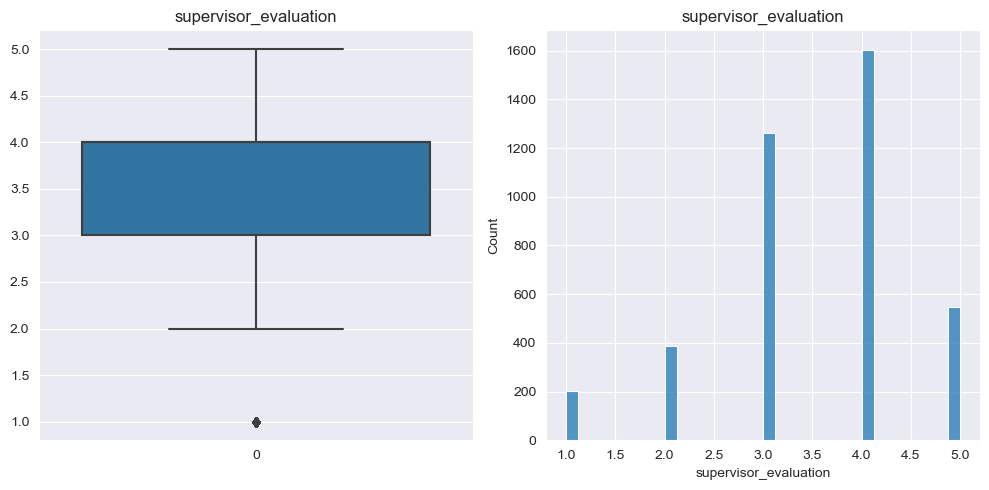

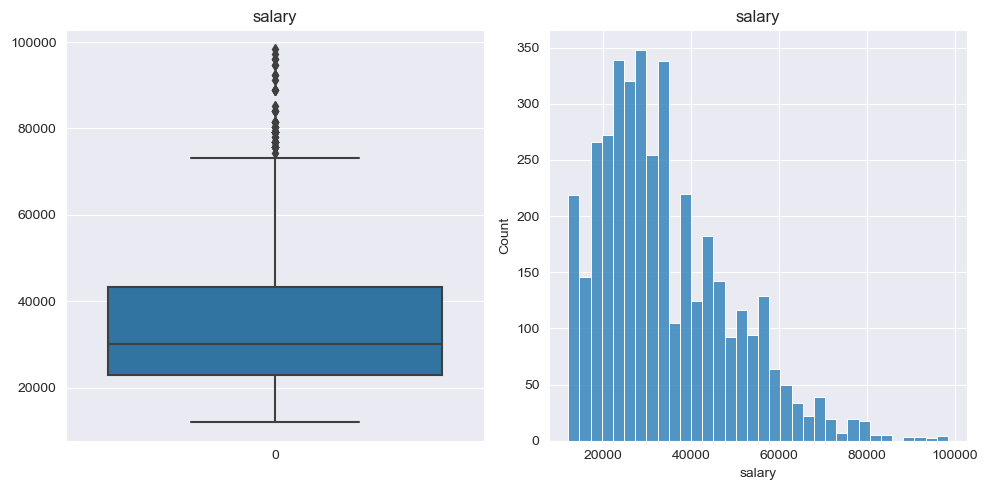

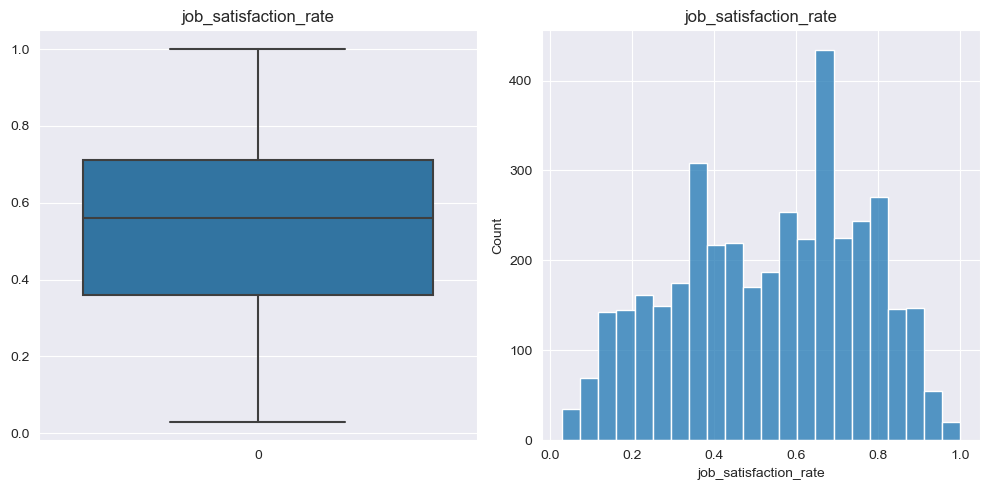

In [57]:
job_satisfaction_num = job_satisfaction_rate[['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']]


for i, num in enumerate(job_satisfaction_num):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs = axs.flatten()
    data = job_satisfaction_num[num]
    sns.boxplot(data=data, ax=axs[0])  # ящик с усами
    axs[0].set_title(num)
    data1 = job_satisfaction_num[num]
    sns.histplot(data=data1, ax=axs[1])  # гистограмма
    axs[1].set_title(num)
    fig.tight_layout()
    plt.show()